# Evaluate

In [1]:
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import stats
from math import sqrt
from statsmodels.formula.api import ols

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression 

from env import host, user, password
import acquire
import prepare

Acquire the data

In [3]:
df = acquire.acquire_zillow()

Clean the data

In [4]:
df = prepare.clean_zillow(df)

Lets take a closer look at out cleaned data

Text(0.5, 1.0, 'Zillow Correlation Heatmap of Trained Data without Scaling')

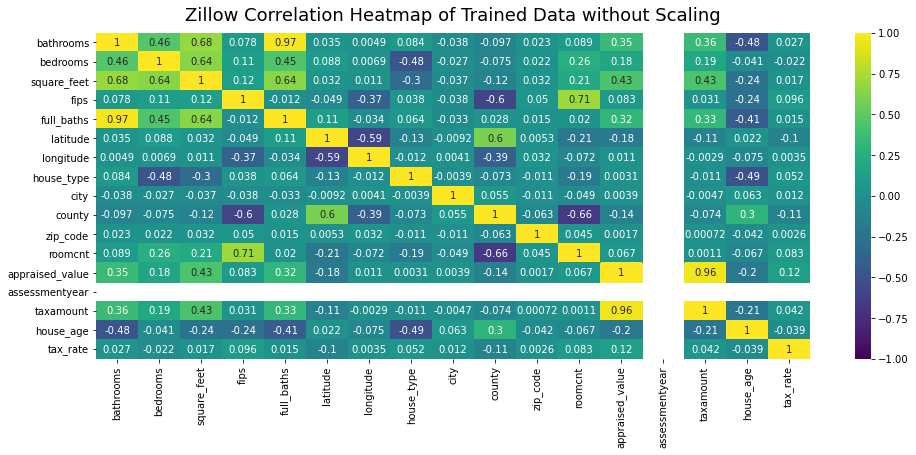

In [5]:
plt.figure(figsize=(16, 6))
corr_map = sns.heatmap(df.corr(), cmap="viridis", vmin=-1, vmax=1, annot=True)
corr_map.set_title('Zillow Correlation Heatmap of Trained Data without Scaling', fontdict={'fontsize':18}, pad=12)
# '-' (negative) is still correlation but is downward slope not upward

- Takeaways
    - my target is `appraised_value`
        - strongest correlations are
            - square_feet
                - 0.61
            - bathrooms
                - 0.51
            - bedrooms
                - 0.29
            - lattitude
                - -0.18
            - county
                - -0.14
            - house_age
                - 0.13
            - tax_rate
                - 0.12

#### Split the data into train, test, and validate

In [6]:
train, validate, test = prepare.split_focused_zillow(df)

Text(0.5, 1.0, 'Zillow Correlation Heatmap of Trained Data without Scaling')

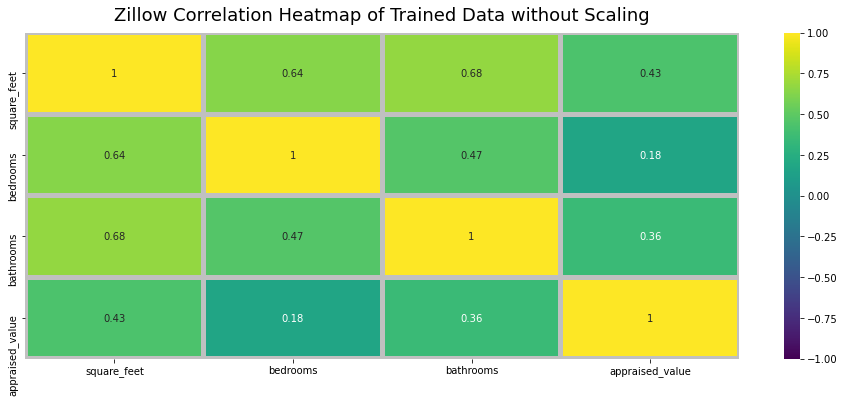

In [7]:
plt.figure(figsize=(16, 6))
sns.heatmap(train.corr(), cmap="viridis", vmin=-1, vmax=1, annot=True, 
                       center=0, linewidths=4, linecolor='silver')
plt.title('Zillow Correlation Heatmap of Trained Data without Scaling', fontsize=18, pad=12)
# '-' (negative) is still correlation but is downward slope not upward

- In the above chart
    - the darker purple represents a stronger positive correlation between two features
    - the lighter the blue the stronger the negative correlation between 2 features
- The strongest correlations to the `appraise_value` feature are:
    - `square_feet`
        - 0.43
            - positive correlation
    - `bathrooms`
        - 0.36
            - positive correlation
    - `bedrooms`
        - 0.18
            - positive correlation

#### Lets scale our train data

In [8]:
train_scaled, validate_scaled, test_scaled = prepare.scale_focused_zillow(train, validate, test)

Lets focus on just train data set while we start exploring and put scaled in our back pocket for later

# Relationships Scatter Plots

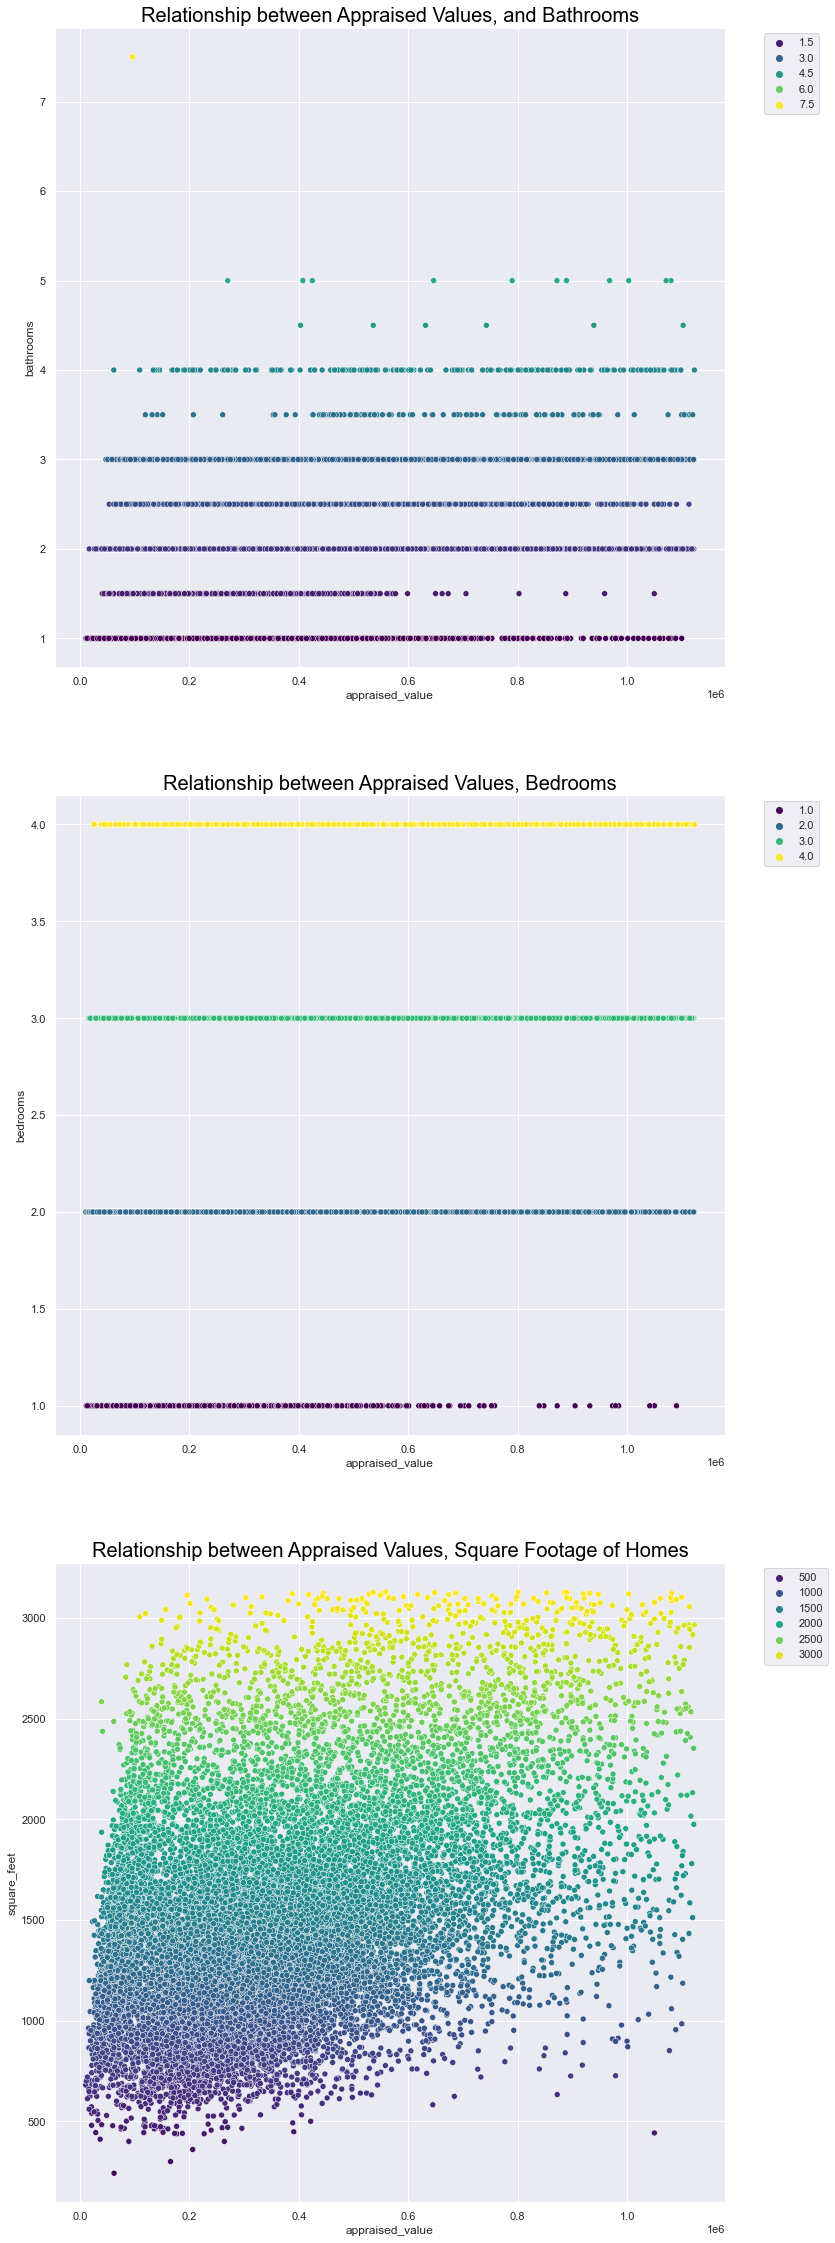

In [31]:
plt.subplots(3, 1, figsize=(12,40), sharey=True)
sns.set(style="darkgrid")

plt.subplot(3,1,1)
plt.title("Relationship between Appraised Values, and Bathrooms", size=20, color='black')
sns.scatterplot(data=train, x='appraised_value', y='bathrooms', hue='bathrooms', palette='viridis')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    
plt.subplot(3,1,2)
plt.title("Relationship between Appraised Values, Bedrooms", size=20, color='black')
sns.scatterplot(data=train, x='appraised_value', y='bedrooms', hue='bedrooms', palette='viridis')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.subplot(3,1,3)
plt.title("Relationship between Appraised Values, Square Footage of Homes", size=20, color='black')
sns.scatterplot(data=train, x='appraised_value', y='square_feet', hue='square_feet', palette='viridis')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


- Takeaways of Relationship Scatter Plots:
    - I can definatly see a relationship between `appraise_value` and:
        - `square_feet`
    - there seems to be a noticable difference in the amount of homes with a low appraised value and low square footage vs. homes with a higher appraised value's square footage
    - Homes with 1 bedroom seem to drop off when appraised values get higher while the 2+ bedroom houses seem to contiue rising with the appraised value
    - `house_type`
        - There are far more of 261
            - Single Family Residential
        - Plenty of 266
            - Confominium
        - Fair amount of 265
            - Cluster Homes
        - Not much of 263
            - Mobile Homes
        - Nearly none of 264 
            - Town House
        -  Nearly none of 260
            - Residential General

#

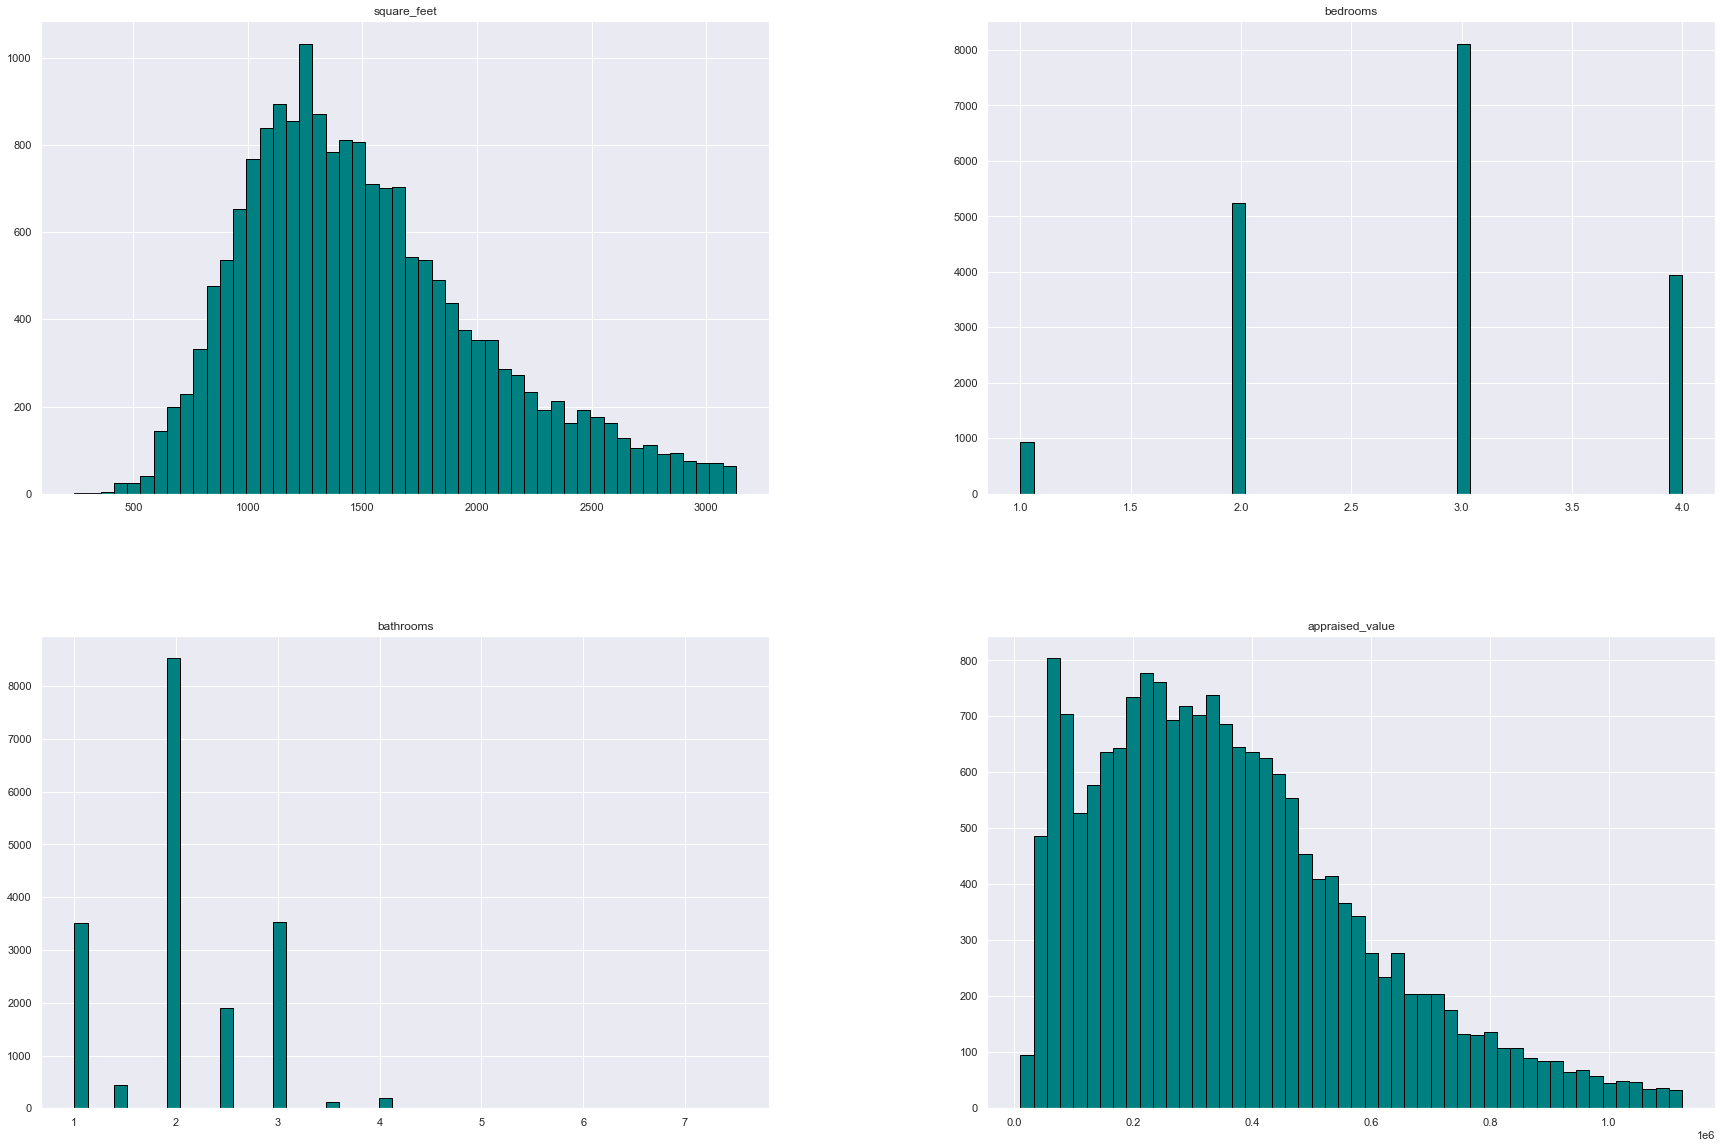

In [12]:
train.hist(bins=50, figsize=(30,20), color='teal', ec='black');

Takeaways:
- There are far more homes with 3 bedrooms than any other
- the bathrooms feature is slightly skewed right
    - but when looking at the outliers I would loose too many values if I were to remove 4-7 bathroom hokmes
- There is a steady decline in the amount of houses being appraied the higher the appraised vvalue gets.
    - this is porbably due to homes that cost a few million dollars not being in such high demand as home under a million

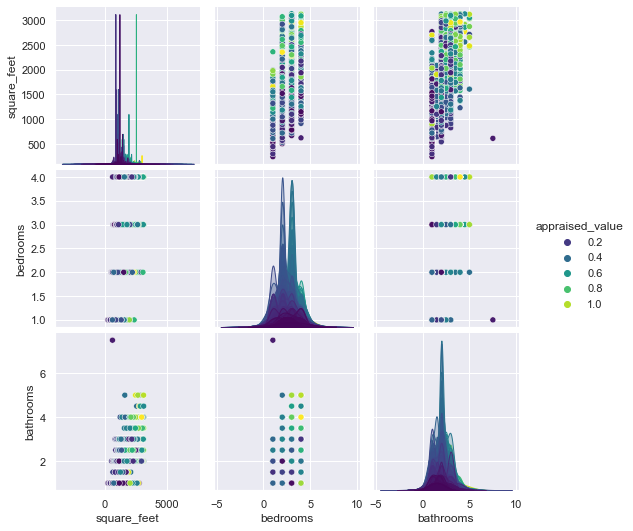

In [13]:
#break it down by hue
sns.pairplot(train, hue = 'appraised_value', palette='viridis')
#now it is broken down by smoker vs non msoker

Takeaways:
- We can ignore where features overlap because it is not helpful.
- It seems as though if homes wiht more bathrooms and larger amount of square feet tend to be appraised at a higher amount.
    - this is seen in the top right graph
        - the yellow which indicated the higher apppraisal rate takes up mosre population the higher the bathroom number and amount of square feet get
            - 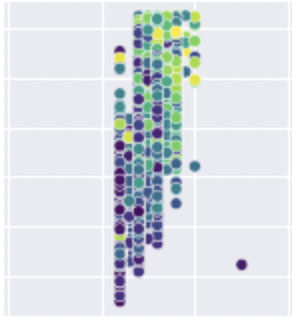 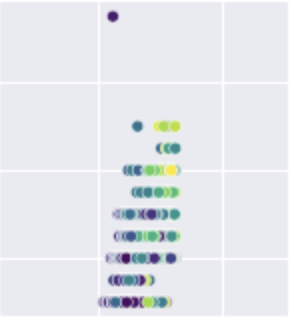
- we can see a gradual increase in appraisal price in the bedrooms and bathrooms relationship.
    - when both features are high we move into higher appraisal values
        - indicated by the green
    - and the lower amount the features are the lower the amount the appraisal value seems to become
        - indicated by dark blue
            - 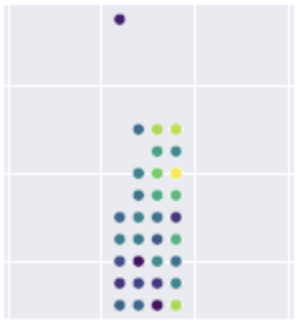

# Explore Bathrooms Features

In [14]:
null_hypothesis = "There is no correlation between number of bathrooms and appraised value."
alt_hypothesis = "There is a correlation between number of bathrooms and appraised value."
confidence_level = .95
a = 1 - confidence_level

In [15]:
x = train.bathrooms
y= train.appraised_value

corr, p = stats.pearsonr(x, y)
print(f' The correlation between Bathrooms and the Appraised value is: ', corr)
print(f' The P value between Bathrooms and Appraised Value is: ', p)

 The correlation between Bathrooms and the Appraised value is:  0.3561501661540747
 The P value between Bathrooms and Appraised Value is:  0.0


In [16]:
if p < a:
    print(f"Reject null hypothesis: '{null_hypothesis}'")
    print(' ')
    print(f"We now move forward with our alternative hypothesis: '{alt_hypothesis}'")
    print(' ')
    if 0 < corr < .6:
        print("This is a weak positive correlation.")
    elif .6 < corr < 1:
        print("That is a strong positive correlation.")
    elif -.6 < corr < 0:
        print("This is a weak negative correlation.")
    elif -1 < corr < -.6:
        print("That is a strong negative correlation.")
    
else : 
    print("Fail to reject the null hypothesis.")

Reject null hypothesis: 'There is no correlation between number of bathrooms and appraised value.'
 
We now move forward with our alternative hypothesis: 'There is a correlation between number of bathrooms and appraised value.'
 
This is a weak positive correlation.


<AxesSubplot:xlabel='bathrooms', ylabel='Density'>

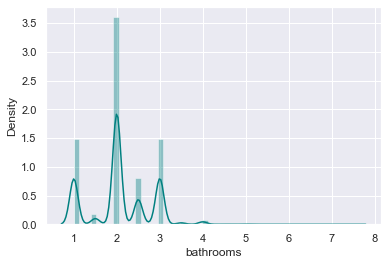

In [17]:
sns.distplot(train.bathrooms, kde=True, color='teal')

<AxesSubplot:xlabel='bathrooms', ylabel='appraised_value'>

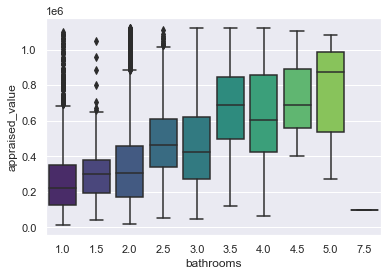

In [18]:
sns.boxplot(y='appraised_value', x ='bathrooms', data = train, palette='viridis')

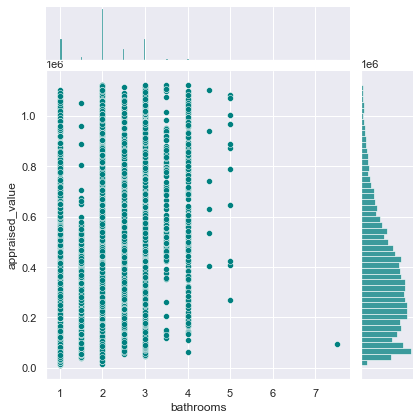

In [19]:
sns.jointplot(data = train, x = 'bathrooms', y = 'appraised_value', color='teal')

# Explore Bedrooms

In [20]:
null_hypothesis = "There is no correlation between number of bedrooms and appraised value."
alt_hypothesis = "There is a correlation between number of bedrooms and appraised value."
confidence_level = .95
a = 1 - confidence_level

In [21]:
x = train.bedrooms
y= train.appraised_value

corr, p = stats.pearsonr(x, y)
print(f' The correlation between Bathrooms and the Appraised value is: ', corr)
print(f' The P value between Bathrooms and Appraised Value is: ', p)

 The correlation between Bathrooms and the Appraised value is:  0.1774791679889962
 The P value between Bathrooms and Appraised Value is:  7.710497170607393e-129


In [22]:
if p < a:
    print(f"Reject null hypothesis: '{null_hypothesis}'")
    print(' ')
    print(f"We now move forward with our alternative hypothesis: '{alt_hypothesis}'")
    print(' ')
    if 0 < corr < .6:
        print("This is a weak positive correlation.")
    elif .6 < corr < 1:
        print("That is a strong positive correlation.")
    elif -.6 < corr < 0:
        print("This is a weak negative correlation.")
    elif -1 < corr < -.6:
        print("That is a strong negative correlation.")
    
else : 
    print("Fail to reject the null hypothesis.")

Reject null hypothesis: 'There is no correlation between number of bedrooms and appraised value.'
 
We now move forward with our alternative hypothesis: 'There is a correlation between number of bedrooms and appraised value.'
 
This is a weak positive correlation.


<AxesSubplot:xlabel='bedrooms', ylabel='Density'>

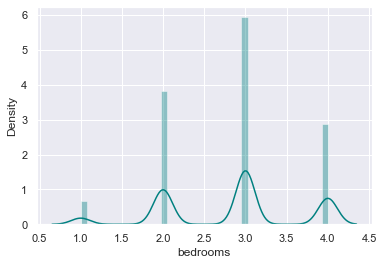

In [23]:
sns.distplot(train.bedrooms, kde=True, color='teal')

<AxesSubplot:xlabel='bedrooms', ylabel='appraised_value'>

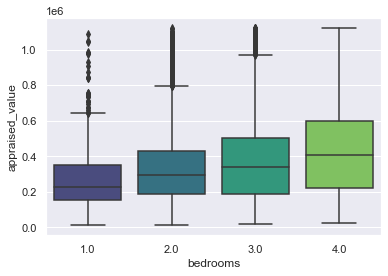

In [24]:
sns.boxplot(y='appraised_value', x ='bedrooms', data = train, palette='viridis')

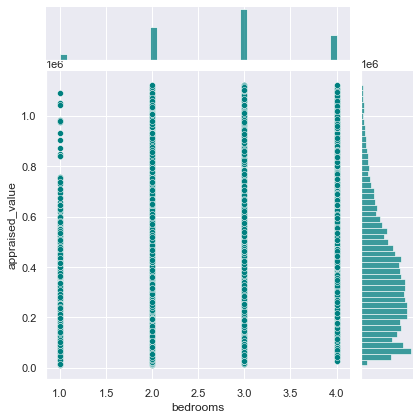

In [25]:
sns.jointplot(data = train, x = 'bedrooms', y = 'appraised_value', color='teal')

# Explore Square Feet

In [26]:
null_hypothesis = "There is no correlation between a homes square footage and appraised value."
alt_hypothesis = "There is a correlation between square feet and appraised value."
confidence_level = .95
a = 1 - confidence_level

In [27]:
x = train.square_feet
y= train.appraised_value

corr, p = stats.pearsonr(x, y)
print(f' The correlation between Bathrooms and the Appraised value is: ', corr)
print(f' The P value between Bathrooms and Appraised Value is: ', p)

 The correlation between Bathrooms and the Appraised value is:  0.43158543063336313
 The P value between Bathrooms and Appraised Value is:  0.0


In [28]:
if p < a:
    print(f"Reject null hypothesis: '{null_hypothesis}'")
    print(' ')
    print(f"We now move forward with our alternative hypothesis: '{alt_hypothesis}'")
    print(' ')
    if 0 < corr < .6:
        print("This is a weak positive correlation.")
    elif .6 < corr < 1:
        print("That is a strong positive correlation.")
    elif -.6 < corr < 0:
        print("This is a weak negative correlation.")
    elif -1 < corr < -.6:
        print("That is a strong negative correlation.")
    
else : 
    print("Fail to reject the null hypothesis.")

Reject null hypothesis: 'There is no correlation between a homes square footage and appraised value.'
 
We now move forward with our alternative hypothesis: 'There is a correlation between square feet and appraised value.'
 
This is a weak positive correlation.


<AxesSubplot:xlabel='square_feet', ylabel='Density'>

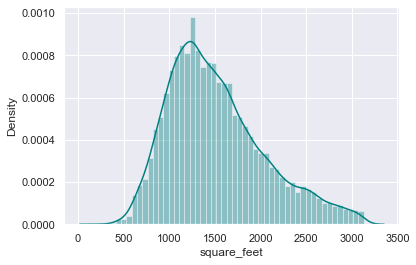

In [29]:
sns.distplot(train.square_feet, kde=True, color='teal')

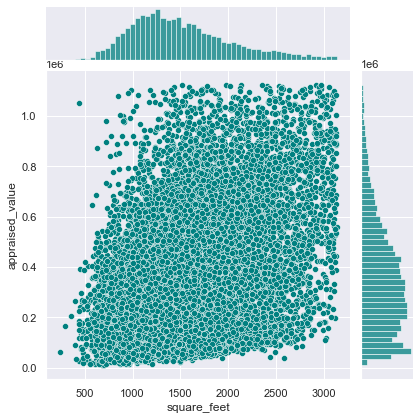

In [30]:
sns.jointplot(data = train, x = 'square_feet', y = 'appraised_value', color='teal')

Takeaways:
- All three features seem to be correlated to the appraised_value feature.
    - The correlations for all 3 are pretty low
        - but will all still be helpful for the model.

 The correlation between Bathrooms and the Appraised value is:  0.1774791679889962
 The P value between Bathrooms and Appraised Value is:  7.710497170607393e-129
 
Reject null hypothesis: 'There is no correlation between number of bedrooms and appraised value.'
 
We now move forward with our alternative hypothesis: 'There is a correlation between number of bedrooms and appraised value.'
 
This is a weak positive correlation.


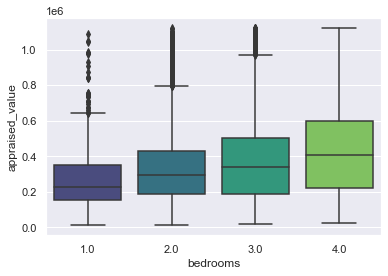

In [44]:
def bedroom_corr():
    '''Runs correlation test between bedrooms and appraised value
    plot a distribution plot
    plot a boxplot'''
    null_hypothesis = "There is no correlation between number of bedrooms and appraised value."
    alt_hypothesis = "There is a correlation between number of bedrooms and appraised value."
    confidence_level = .95
    a = 1 - confidence_level
    x = train.bedrooms
    y= train.appraised_value

    corr, p = stats.pearsonr(x, y)
    print(f' The correlation between Bathrooms and the Appraised value is: ', corr)
    print(f' The P value between Bathrooms and Appraised Value is: ', p)
    print(' ')
    if p < a:
        print(f"Reject null hypothesis: '{null_hypothesis}'")
        print(' ')
        print(f"We now move forward with our alternative hypothesis: '{alt_hypothesis}'")
        print(' ')
        if 0 < corr < .6:
            print("This is a weak positive correlation.")
        elif .6 < corr < 1:
            print("That is a strong positive correlation.")
        elif -.6 < corr < 0:
            print("This is a weak negative correlation.")
        elif -1 < corr < -.6:
            print("That is a strong negative correlation.")

    else : 
        print("Fail to reject the null hypothesis.")
    # boxplot
    sns.boxplot(y='appraised_value', x ='bedrooms', data = train, palette='viridis')
bedroom_corr()

 The correlation between Bathrooms and the Appraised value is:  0.43158543063336313
 The P value between Bathrooms and Appraised Value is:  0.0
 
Reject null hypothesis: 'There is no correlation between a homes square footage and appraised value.'
 
We now move forward with our alternative hypothesis: 'There is a correlation between square feet and appraised value.'
 
This is a weak positive correlation.


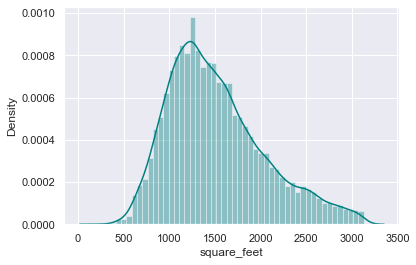

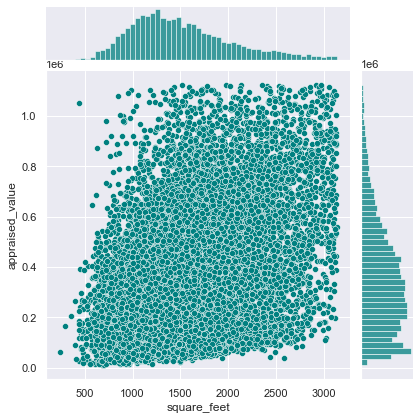

In [47]:
def square_feet_corr():
    '''Runs correlation test between bedrooms and appraised value
    plot a distribution plot
    plot a jointplot'''
    null_hypothesis = "There is no correlation between a homes square footage and appraised value."
    alt_hypothesis = "There is a correlation between square feet and appraised value."
    confidence_level = .95
    a = 1 - confidence_level
    x = train.square_feet
    y= train.appraised_value

    corr, p = stats.pearsonr(x, y)
    print(f' The correlation between Bathrooms and the Appraised value is: ', corr)
    print(f' The P value between Bathrooms and Appraised Value is: ', p)
    print(' ')
    if p < a:
        print(f"Reject null hypothesis: '{null_hypothesis}'")
        print(' ')
        print(f"We now move forward with our alternative hypothesis: '{alt_hypothesis}'")
        print(' ')
        if 0 < corr < .6:
            print("This is a weak positive correlation.")
        elif .6 < corr < 1:
            print("That is a strong positive correlation.")
        elif -.6 < corr < 0:
            print("This is a weak negative correlation.")
        elif -1 < corr < -.6:
            print("That is a strong negative correlation.")

    else : 
        print("Fail to reject the null hypothesis.")
    #distplot
    sns.distplot(train.square_feet, kde=True, color='teal')
    #jointplot
    sns.jointplot(data = train, x = 'square_feet', y = 'appraised_value', color='teal')
square_feet_corr()